In [1]:
import os
import string
import datetime
import folium
import pandas as pd
import geopy.distance

# Paths of all the datasets
train_dataset_path = os.getcwd()+'\\Train'
test_dataset_path = os.getcwd()+'\\Test'
labeled_data_path = os.getcwd()+'\\Label'

# Define a function to convert numbers into corresponding letter labels
def num_to_letter(num):
    '''
    num         : number that we have to convert
    '''
    return string.ascii_uppercase[num]

# Define a function to check whether the path passes through the grid
def is_path_in_grid(south, west, north, east, path_points):
    '''
    south       : minimum latitude
    west        : minimum longitude
    north       : maximum latitude
    east        : maximum longitude
    path_points : coordinate points
    '''
    for lat, lng in path_points:
        if south <= lat <= north and west <= lng <= east:
            return True
    return False

# Create a function to get the grid label of the coordinate point
def get_grid_label(lat, lng, final_grids):
    '''
    lat         : latitude
    lng         : longitude
    final_grids : all cells and their minimum/maximum latitude/longitude
    '''
    for south, west, north, east, grid_label in final_grids:
        if south <= lat <= north and west <= lng <= east:
            return grid_label
    return None

# Approximate border coordinates of South Korea
south_korea_bounds = [32, 124, 39, 132]
 
# Create a map 
m = folium.Map(location=[(south_korea_bounds[0] + south_korea_bounds[2]) / 2,
                         (south_korea_bounds[1] + south_korea_bounds[3]) / 2],
               zoom_start=7)

# Read waypoint
path_points = []
directory = train_dataset_path
path_dataframes = []

for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(directory, filename)
        data = pd.read_csv(file_path, encoding='utf-8')
        path_dataframes.append(data)
        points = data[['lat', 'lng']].values.tolist()
        path_points.extend(points)
 
        # draw a line on the map
        folium.PolyLine(points, color='red', weight=2.5, opacity=1).add_to(m)

# Initialize grid queue
grid_queue = []
final_grids = []  # Used to store the final small grid
initial_lat_step = (south_korea_bounds[2] - south_korea_bounds[0]) / 26
initial_lon_step = (south_korea_bounds[3] - south_korea_bounds[1]) / 26
#initial_lat_step *= 0.94
#initial_lon_step *= 0.94
 
for i in range(26):
    for j in range(26):
        south = south_korea_bounds[0] + i * initial_lat_step
        north = south_korea_bounds[0] + (i + 1) * initial_lat_step
        west = south_korea_bounds[1] + j * initial_lon_step
        east = south_korea_bounds[1] + (j + 1) * initial_lon_step
        grid_queue.append((south, west, north, east, num_to_letter(i) + num_to_letter(j)))

# Process grid queue
min_size_km = 1  # Minimum grid size (km)
subdivisions = ['A', 'B', 'C', 'D']  # Split label
while grid_queue:
    south, west, north, east, grid_label = grid_queue.pop(0)
    grid_size_km = min(geopy.distance.distance((south, west), (south, east)).km,
                       geopy.distance.distance((south, west), (north, west)).km)
 
    if grid_size_km > min_size_km and is_path_in_grid(south, west, north, east, path_points):
        mid_lat = (south + north) / 2
        mid_lon = (west + east) / 2
        grid_queue.append((south, west, mid_lat, mid_lon, grid_label + 'C'))
        grid_queue.append((mid_lat, west, north, mid_lon, grid_label + 'A'))
        grid_queue.append((south, mid_lon, mid_lat, east, grid_label + 'D'))
        grid_queue.append((mid_lat, mid_lon, north, east, grid_label + 'B'))
    else:
        final_grids.append((south, west, north, east, grid_label))
        folium.Rectangle(
            bounds=[[south, west], [north, east]],
            color='#0000FF',
            fill=True,
            fill_opacity=0.1
        ).add_to(m)
        # Add a green label to the center of the grid
        folium.Marker(
            location=[(south + north) / 2, (west + east) / 2],
            icon=folium.DivIcon(html=f'<div style="font-size: 8pt; color: yellow;">{grid_label}</div>')
        ).add_to(m)

grid_data = {
    'Grid Name': [label for _, _, _, _, label in final_grids],
    'Min Latitude, Min Longitude': [(south, west) for south, west, _, _, _ in final_grids],
    'Max Latitude, Max Longitude': [(north, east) for _, _, north, east, _ in final_grids]
}
grid_df = pd.DataFrame(grid_data)

# Save the grid information to a CSV file
grid_df.to_csv('grid_information_with_paths.csv', index=False)

# Assign final grid labels to waypoints
for data in path_dataframes:
    data['grid_label'] = data.apply(lambda row: get_grid_label(row['lat'], row['lng'], final_grids), axis=1)

# checking if the directory demo_folder exist or not. 
if not os.path.exists(labeled_data_path):  
    os.makedirs(labeled_data_path)

# Save the updated DataFrame to a new CSV file
for idx, df in enumerate(path_dataframes):
    labeled_file = datetime.datetime.now().strftime("%Y%m%d%H%M%S%f")
    df.to_csv(f'Label/{labeled_file}.csv', index=False)

# Save or show map
m.save('south_korea_grid_map_with_subdivided_paths.html')

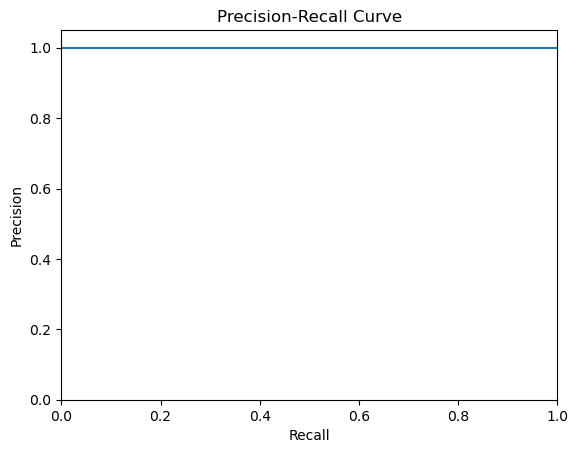

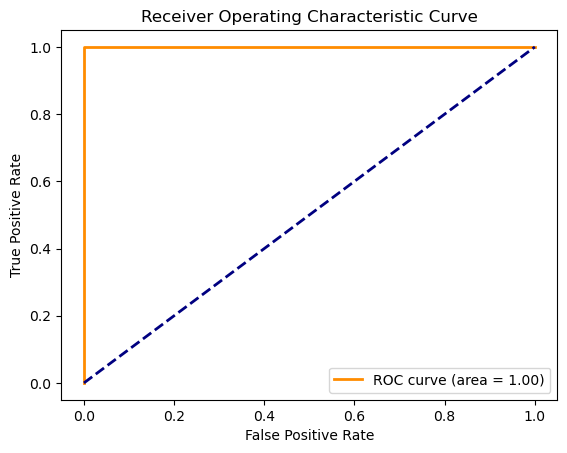

Accuracy: 1.0
Confusion Matrix:
[[  7   0]
 [  0 114]]
Recall: 1.0
Precision: 1.0


In [3]:
import os
import ast
import numpy as np
import pandas as pd
from scipy.stats import iqr
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, auc

# Paths of all the datasets
labeled_data_path = os.getcwd()+'\\Label'
test_dataset_path = os.getcwd()+'\\Test'
evaluation_file = os.getcwd()+'\\F1_evaluation.csv'
test_label_evaluation_file = os.getcwd()+'\\F1_test_label_evaluation.csv'

# Create a new list with non-consecutive duplicates removed
def CollapseRecurringLabels(original_list):

    # Initialize the result list with the first element of the original list
    result_list = [original_list[0]]  

    for i in range(1, len(original_list)):
        if original_list[i] != original_list[i - 1]:
            result_list.append(original_list[i])

    return result_list

def compute_threshold(frequencies):
    data = frequencies
    median_value = np.median(data)
    iqr_value = iqr(data)
    k = 2

    threshold = median_value + k * iqr_value

    return threshold

def find_label_for_point(lat, lng, grid_info):
    for index, row in grid_info.iterrows():
        # Convert string representations to tuples
        min_lat, min_lng = ast.literal_eval(row['Min Latitude, Min Longitude'])
        max_lat, max_lng = ast.literal_eval(row['Max Latitude, Max Longitude'])

        if min_lat <= lat <= max_lat and min_lng <= lng <= max_lng:
            return row['Grid Name']

    return None

# Step 1: Load Data and Collapse Recursive Data
frequency_dict = {}

for file_name in os.listdir(labeled_data_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(labeled_data_path, file_name)
        df = pd.read_csv(file_path)

        # Collapse recursive data in 'grid_label' column
        labels = df['grid_label'].tolist()
        unique_labels = CollapseRecurringLabels(labels)
        df_ = pd.DataFrame(unique_labels, columns=['grid_label'])

        # Step 2: Compute Frequency of Each Label
        label_counts = df_['grid_label'].value_counts().to_dict()

        # Step 3: Update Frequency Dictionary
        for label, count in label_counts.items():
            frequency_dict[label] = frequency_dict.get(label, 0) + count

# Create an empty DataFrame
evaluation_df = pd.DataFrame(columns=['cell_GeoLabel', 'lF', 'F1'])
evaluation_df.to_csv(evaluation_file, index=False)

# Create an empty DataFrame
testeval_df = pd.DataFrame(columns=['cell_GeoLabel', 'cell_Answer'])
testeval_df.to_csv(test_label_evaluation_file, index=False)

# Save Frequency Dictionary to CSV
frequency_df = pd.DataFrame(list(frequency_dict.items()), columns=['Label', 'Frequency'])
frequency_df.to_csv('label_frequencies.csv', index=False)

# Compute the threshold based on Frequency Dictionary
labels = frequency_df['Frequency'].tolist()
threshold = 3 #compute_threshold(labels)

# Load the grid information from the CSV file
grid_info_file = 'grid_information_with_paths.csv'
grid_info = pd.read_csv(grid_info_file)

latitudes = list()
longitudes = list()
anomalies = list()

# Read the test CSV file

for filename in os.listdir(test_dataset_path):
    if filename.endswith('.csv'):
        csv_file_path = os.path.join(test_dataset_path, filename)
        df = pd.read_csv(csv_file_path)
        previous_label = ""

        # Iterate over rows in a streaming way
        for index, row in df.iterrows():
            # Process the current row
            lat = row['lat']
            lng = row['lng']

            label = find_label_for_point(lat, lng, grid_info)

            # Check if the label exists in label_frequencies.csv
            if label == previous_label:
                pass
            else:
                previous_label = label

                latitudes.append(lat)
                longitudes.append(lng)

                if pd.notna(label):
                    if label in frequency_df['Label'].values:
                        # Get the corresponding frequency
                        frequency = frequency_df.loc[frequency_df['Label'] == label, 'Frequency'].values[0]

                        # Compare with the threshold
                        if frequency >= threshold:
                            Anomaly_type = "N"
                            # print(f"Label: {label} 정상 (Frequency: {frequency})")
                            anomalies.append(0)
                        else:
                            # print(f"Label: {label} 비정상 (Frequency: {frequency})")
                            Anomaly_type = "AN"
                            anomalies.append(1)
                    else:
                        # print(f"Label: {label} 비정상 (Frequency: {frequency})")
                        frequency = 0
                        Anomaly_type = "AN"
                        anomalies.append(1)
                else:
                    # print(f'Label: {label} 비정상 (Frequency: {frequency})')
                    frequency = 0
                    Anomaly_type = "AN"
                    anomalies.append(1)

                current_data = pd.DataFrame({'cell_GeoLabel': [label], 'F1': [Anomaly_type], 'lF': [frequency]})
                evaluation_df = pd.concat([evaluation_df, current_data], ignore_index=True)
                
                if frequency >= 3:
                    bit = 0
                else:
                    bit = 1
                
                current_data2 = pd.DataFrame({'cell_GeoLabel': [label], 'cell_Answer': [bit]})
                testeval_df = pd.concat([testeval_df, current_data2], ignore_index=True)
            
evaluation_df.to_csv(evaluation_file, index=False)
testeval_df.to_csv(test_label_evaluation_file, index=False)

Method = 'F1'

# Read the CSV file
df = pd.read_csv('F1_evaluation.csv')
df_test = pd.read_csv('F1_test_label_evaluation.csv')

# Replace 'AN' with 1 and 'N' with 0 in the 'F1' column
df[Method] = df[Method].replace({'AN': 1, 'N': 0})

result_df = df[['cell_GeoLabel', Method]]
result_df_test = df_test[['cell_GeoLabel', 'cell_Answer']]
accuracy = accuracy_score(result_df_test['cell_Answer'], result_df[Method])
conf_matrix = confusion_matrix(result_df_test['cell_Answer'], result_df[Method])
recall = recall_score(result_df_test['cell_Answer'], result_df[Method], pos_label = 0)
precision = precision_score(result_df_test['cell_Answer'], result_df[Method], pos_label = 0)

precision_curve, recall_curve, _ = precision_recall_curve(result_df_test['cell_Answer'], result_df[Method])
fpr, tpr, _ = roc_curve(result_df_test['cell_Answer'], result_df[Method])
roc_auc = auc(fpr, tpr)

# Precision-Recall 곡선 시각화
plt.figure()
plt.step(recall_curve, precision_curve, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Recall:", recall)
print("Precision:", precision)

c:\Users\Hyeuk\Anaconda3\envs\py3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hyeuk\Anaconda3\envs\py3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Hyeuk\Anaconda3\envs\py3\lib\site-packages\sklearn\metrics\_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


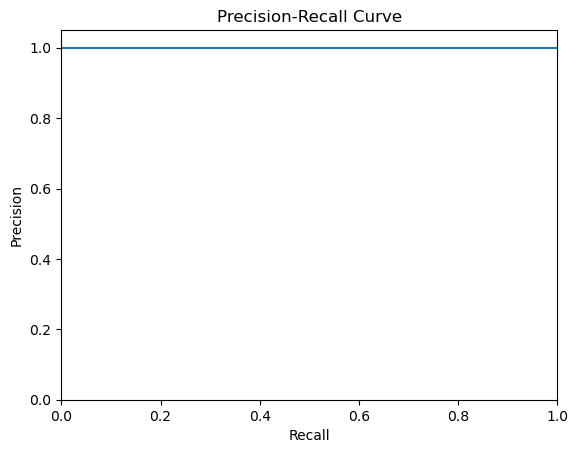

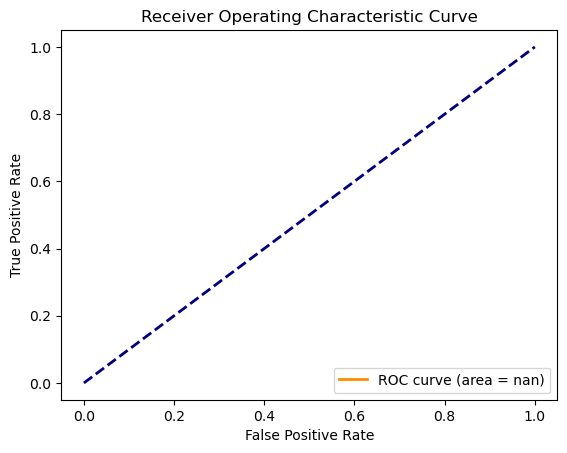

Accuracy: 1.0
Confusion Matrix:
[[10]]
Recall: 0.0
Precision: 0.0


In [34]:
import os
import ast
import numpy as np
import pandas as pd

from scipy.stats import iqr
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, auc

# Paths of all the datasets
labeled_data_path = os.getcwd()+'\\Label'
test_dataset_path = os.getcwd()+'\\Test'
evaluation_file = os.getcwd()+'\\F2_evaluation.csv'
test_label_evaluation_file = os.getcwd()+'\\F2_test_label_evaluation.csv'

# Create a new list with non-consecutive duplicates removed
def CollapseRecurringLabels(original_list):

    # Initialize the result list with the first element of the original list
    result_list = [original_list[0]]  

    for i in range(1, len(original_list)):
        if original_list[i] != original_list[i - 1]:
            result_list.append(original_list[i])

    return result_list

def compute_threshold(frequencies):
    data = frequencies
    median_value = np.median(data)
    iqr_value = iqr(data)
    k = 2
    threshold = median_value + k * iqr_value
    return threshold

def find_label_for_point(lat, lng, grid_info):
    for index, row in grid_info.iterrows():
        # Convert string representations to tuples
        min_lat, min_lng = ast.literal_eval(row['Min Latitude, Min Longitude'])
        max_lat, max_lng = ast.literal_eval(row['Max Latitude, Max Longitude'])

        if min_lat <= lat <= max_lat and min_lng <= lng <= max_lng:
            return row['Grid Name']

    return None

# Load Data and Collapse Recursive Data
pair_frequency = defaultdict(int)

for file_name in os.listdir(labeled_data_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(labeled_data_path, file_name)
        df = pd.read_csv(file_path)
        
        # Collapse recursive data in 'grid_label' column
        labels = df['grid_label'].tolist()
        unique_labels = CollapseRecurringLabels(labels)
        
        # Iterate through the list to create pairs and count frequencies
        previous_label = None
        
        for label in unique_labels:
            if previous_label is not None:
                pair = (previous_label, label)
                pair_frequency[pair] += 1

            # Update the previous label for the next iteration
            previous_label = label

# Create an empty DataFrame
evaluation_df = pd.DataFrame(columns=['pair_GeoLabel', 'PF', 'F2'])
evaluation_df.to_csv(evaluation_file, index=False)

# Create an empty DataFrame
testeval_df = pd.DataFrame(columns=['pair_GeoLabel', 'pair_Answer'])
testeval_df.to_csv(test_label_evaluation_file, index=False)

# Save Frequency Dictionary to CSV
frequency_df = pd.DataFrame(list(pair_frequency.items()), columns=['Label', 'Frequency'])
frequency_df.to_csv('pair_frequencies.csv', index=False)

# Compute the threshold based on Frequency Dictionary
f_labels = frequency_df['Frequency'].tolist()
threshold = 3 #compute_threshold(f_labels)

# Load the grid information from the CSV file
grid_info_file = 'grid_information_with_paths.csv'
grid_info = pd.read_csv(grid_info_file)

# Read the test CSV file
for filename in os.listdir(test_dataset_path):
    if filename.endswith('.csv'):
        csv_file_path = os.path.join(test_dataset_path, filename)
        df = pd.read_csv(csv_file_path)
        previous_label = ""
        RecurringLabels = ""

        # Iterate over rows in a streaming way
        for index, row in df.iterrows():
            # Process the current row
            lat = row['lat']
            lng = row['lng']

            label = find_label_for_point(lat, lng, grid_info)

            # Check if the pair exists in pair_frequencies.csv
            if label == RecurringLabels:
                pass
            else:
                RecurringLabels = label

                if previous_label == '' and pd.notna(label):
                    Anomaly_type = ''
                    frequency = ''
                    pair = (previous_label, label)
                    pass
                
                elif pd.notna(label) and pd.notna(previous_label):
                    pair = (previous_label, label)

                    if frequency_df['Label'].isin([pair]).any():
                        # Get the corresponding frequency
                        frequency = frequency_df.loc[frequency_df['Label'] == pair, 'Frequency'].values[0]
                        print(f"Label: {label} 정상 (Frequency: {frequency})")
                        # Compare with the threshold
                        if frequency >= threshold:
                            Anomaly_type = "N"
                        else:
                            print(f"Label: {label} 비정상 (Frequency: {frequency})")
                            Anomaly_type = "AN"
                    else:
                        print(f"Label: {label} 비정상 (Frequency: {frequency})")
                        frequency = 0
                        Anomaly_type = "AN"
                else:
                    print(f"Label: {label} 비정상 (Frequency: {frequency})")
                    frequency = 0
                    Anomaly_type = "AN"
                
                if frequency == '':
                    frequency = 0
                    Anomaly_type = 'AN'

                if frequency >= 3:
                    bit = 0
                else:
                    bit = 1
                    
                current_data = pd.DataFrame({'pair_GeoLabel': [label], 'PF': [frequency], 'F2': [Anomaly_type]})
                evaluation_df = pd.concat([evaluation_df, current_data], ignore_index=True)
                
                current_data2 = pd.DataFrame({'pair_GeoLabel': [label], 'pair_Answer': [bit]})
                testeval_df = pd.concat([testeval_df, current_data2], ignore_index=True)

evaluation_df.to_csv(evaluation_file, index=False)
testeval_df.to_csv(test_label_evaluation_file, index=False)

Method = 'F2'

# Read the CSV file
df = pd.read_csv('F2_evaluation.csv')
df_test = pd.read_csv('F2_test_label_evaluation.csv')

# Replace 'AN' with 1 and 'N' with 0 in the 'F1' column
df[Method] = df[Method].replace({'AN': 1, 'N': 0})

result_df = df[['pair_GeoLabel', Method]]
result_df_test = df_test[['pair_GeoLabel', 'pair_Answer']]
accuracy = accuracy_score(result_df_test['pair_Answer'], result_df[Method])
conf_matrix = confusion_matrix(result_df_test['pair_Answer'], result_df[Method])
recall = recall_score(result_df_test['pair_Answer'], result_df[Method], pos_label = 0)
precision = precision_score(result_df_test['pair_Answer'], result_df[Method], pos_label = 0)

precision_curve, recall_curve, _ = precision_recall_curve(result_df_test['pair_Answer'], result_df[Method])
fpr, tpr, _ = roc_curve(result_df_test['pair_Answer'], result_df[Method])
roc_auc = auc(fpr, tpr)

# Precision-Recall 곡선 시각화
plt.figure()
plt.step(recall_curve, precision_curve, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Recall:", recall)
print("Precision:", precision)

Label: UJCBD 비정상 (Frequency: 0)
Label: UJCD 비정상 (Frequency: 0)
Label: UJCCDBD 비정상 (Frequency: 0)
Label: UJCCDBC 정상 (Frequency: 0)
Label: UJCCDAD 정상 (Frequency: 0)
Label: UJCCDAB 정상 (Frequency: 0)
Label: UJCCDAD 정상 (Frequency: 0)
Label: UJCCDAC 정상 (Frequency: 0)
Label: UJCCDAA 정상 (Frequency: 0)
Label: UJCCDAC 정상 (Frequency: 0)


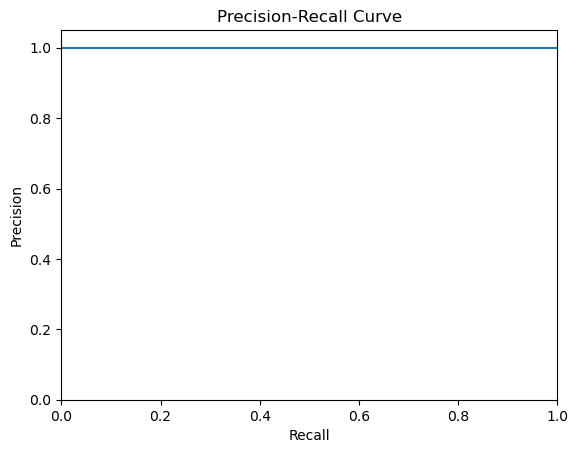

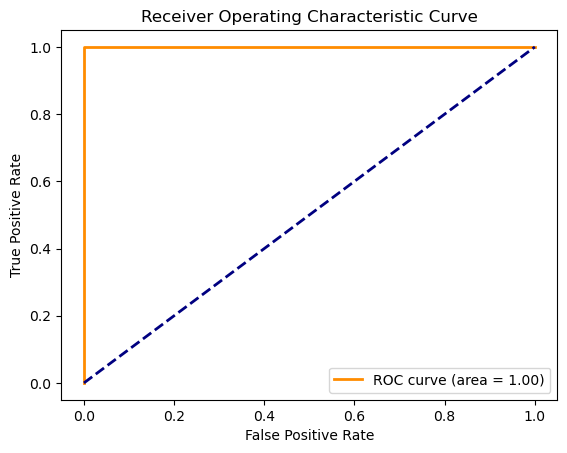

Accuracy: 1.0
Confusion Matrix:
[[7 0]
 [0 3]]
Recall: 1.0
Precision: 1.0


In [36]:
import pandas as pd
import os
import ast
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, roc_curve, auc


# Paths of all the datasets
labeled_data_path = os.getcwd()+'\\Label'
test_dataset_path = os.getcwd()+'\\Test'
evaluation_file = os.getcwd()+'\\S_evaluation.csv'
# test_label_evaluation_file = os.getcwd()+'\\S_test_label_evaluation.csv'
test_label_evaluation_file = os.getcwd()+'\\F1_test_label_evaluation.csv'
geo_trace_pts = {} #전체 중복 경로 횟수

def jaro_similarity(list1, list2):
    # 두 리스트의 길이를 구함
    len_list1 = len(list1)
    len_list2 = len(list2)

    # 두 리스트 중에서 더 긴 길이를 기준으로 함
    max_len = max(len_list1, len_list2)

    # 일치하는 값의 개수를 세기 위한 변수 초기화
    match_count = 0

    # 일치하는 값의 인덱스를 저장하기 위한 리스트 초기화
    matches_list1 = [False] * len_list1
    matches_list2 = [False] * len_list2

    # 첫 번째 단계: 일치하는 값 세기
    for i in range(len_list1):
        start = max(0, i - int(max_len / 2))
        end = min(i + int(max_len / 2) + 1, len_list2)

        for j in range(start, end):
            if not matches_list2[j] and list1[i] == list2[j]:
                matches_list1[i] = True
                matches_list2[j] = True
                match_count += 1
                break

    # 일치하는 값이 하나도 없으면 0 반환
    if match_count == 0:
        return 0.0

    # 두 번째 단계: 일치하는 값의 순서에 따라 가중치 적용
    transpositions = 0
    k = 0
    for i in range(len_list1):
        if matches_list1[i]:
            while not matches_list2[k]:
                k += 1

            if list1[i] != list2[k]:
                transpositions += 1

            k += 1

    # 유사도 계산
    jaro_similarity = ((match_count / len_list1 + match_count / len_list2 + (match_count - transpositions / 2) / match_count)/ 3.0)

    return jaro_similarity

def com_cell(label):
    
    if label in cell:
        print(f"Label: {label} 정상")
        return True
    else:
        print(f"Label: {label} 비정상")
        return False

# Create a function to get the grid label of the coordinate point
def find_label_for_point(lat, lng, grid_info):
    for index, row in grid_info.iterrows():
        # Convert string representations to tuples
        min_lat, min_lng = ast.literal_eval(row['Min Latitude, Min Longitude'])
        max_lat, max_lng = ast.literal_eval(row['Max Latitude, Max Longitude'])

        if min_lat <= lat <= max_lat and min_lng <= lng <= max_lng:
            return row['Grid Name']

    return None

# 디렉토리 내의 모든 CSV 파일 가져오기
csv_files = [f for f in os.listdir(labeled_data_path) if f.endswith('.csv')]

# 각 CSV 파일을 다른 데이터프레임에 저장하기 위한 딕셔너리 생성
dfs = {}

# 각 CSV 파일을 읽어서 데이터프레임에 저장
for file in csv_files:
    # CSV 파일의 경로
    file_path = os.path.join(labeled_data_path, file)
    
    # 파일명을 key로 사용하여 데이터프레임 생성
    df_key = os.path.splitext(file)[0]  # 파일명에서 확장자 제거
    dfs[df_key] = pd.read_csv(file_path)['grid_label']
     
    gridDataLabel = 0 # grid lable 중복 제거 변수
    geo_trace = [] #geo trace 리스트
    
    for grid_label in dfs[df_key]:
        if gridDataLabel != grid_label:
            gridDataLabel = grid_label
            geo_trace.append(grid_label)

    if geo_trace == []:
        geo_trace.append(grid_label)

    tuple_geo = tuple(geo_trace)
    geo_trace_pts[tuple_geo] = geo_trace_pts.get(tuple_geo, 0) + 1
    sorted_geo_trace_pts = dict(sorted(geo_trace_pts.items(), key=lambda x: x[1], reverse=True))
    
# 유사도 비교
cell_list = []
pair_list = []
pair_dict = {}
flatten_list = []
flatten_dict = {}

for key1, value1 in sorted_geo_trace_pts.items():
    list1 = list(key1)
    for key2, value2 in sorted_geo_trace_pts.items():
        if key1 == key2:
            continue
        list2 = list(key2)
        if jaro_similarity(list1, list2)>0.80:
            jaro_sim = jaro_similarity(list1, list2)
            cell_list.extend(list2)

cell = set(cell_list)

# Create an empty DataFrame
evaluation_df = pd.DataFrame(columns=['cell_GeoLabel', 'S'])
evaluation_df.to_csv(evaluation_file, index=False)

grid_info_file = 'grid_information_with_paths.csv'
grid_info = pd.read_csv(grid_info_file)
listpath = []
current_label = 'A'

for filename in os.listdir(test_dataset_path):
    if filename.endswith('.csv'):
        csv_file_path = os.path.join(test_dataset_path, filename)
        df = pd.read_csv(csv_file_path)
        previous_label = ""
        
        for index, row in df.iterrows():
            lat = row['lat']
            lng = row['lng']
            
            label = find_label_for_point(lat, lng, grid_info)
            
            if current_label != label:
                current_label = label
                # print("사용자 현재 위치", label)
                if com_cell(label) == True:
                    Anomaly_type = "N"
                else:
                    Anomaly_type = "AN"

                listpath.append(label) 

                current_data = pd.DataFrame({'cell_GeoLabel': [label], 'S': [Anomaly_type]})
                evaluation_df = pd.concat([evaluation_df, current_data], ignore_index=True)

evaluation_df.to_csv(evaluation_file, index=False)

Method = 'S'

# Read the CSV file
df = pd.read_csv('S_evaluation.csv')
# df_test = pd.read_csv('S_test_label_evaluation.csv')
df_test = pd.read_csv('F1_test_label_evaluation.csv')
# Replace 'AN' with 1 and 'N' with 0 in the 'F1' column
df[Method] = df[Method].replace({'AN': 1, 'N': 0})


result_df = df[['cell_GeoLabel', Method]]
result_df_test = df_test[['cell_GeoLabel', 'cell_Answer']]
accuracy = accuracy_score(result_df_test['cell_Answer'], result_df[Method])
conf_matrix = confusion_matrix(result_df_test['cell_Answer'], result_df[Method])
recall = recall_score(result_df_test['cell_Answer'], result_df[Method], pos_label = 0)
precision = precision_score(result_df_test['cell_Answer'], result_df[Method], pos_label = 0)

precision_curve, recall_curve, _ = precision_recall_curve(result_df_test['cell_Answer'], result_df[Method])
fpr, tpr, _ = roc_curve(result_df_test['cell_Answer'], result_df[Method])
roc_auc = auc(fpr, tpr)

# Precision-Recall 곡선 시각화
plt.figure()
plt.step(recall_curve, precision_curve, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

# ROC 곡선 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)
print("Recall:", recall)
print("Precision:", precision)

